# Laboratorio 5 Grupal.
### Nombres:
###          - Aramayo Valdez Joaquin.
###          - Piza Nava Vladimir.
###          - Viza Hoyos Maria Belen.
###          - Mendoza Ovando Carlos Saul.
###          - Solorzano Diego.
### Link Dataset: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?select=list_eval_partition.csv
### Link GitHub:


# Punto 2 - Aprendisaje no supervisado

### Importando librerias

In [1]:
import os
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from PIL import Image # type: ignore
import torch # type: ignore
import torchvision.transforms as transforms # type: ignore
from torchvision import models # type: ignore
from sklearn.cluster import KMeans # type: ignore

import pandas as pd # type: ignore
from sklearn.metrics import accuracy_score # type: ignore

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # type: ignore
import seaborn as sns # type: ignore

### Configuración y Preprocesamiento de Imágenes

 Selecciona el dispositivo de procesamiento (GPU o CPU) y carga imágenes desde una carpeta, convirtiéndolas a RGB y redimensionándolas, con un límite de cantidad definido.

In [2]:
# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar las imágenes
def load_images(image_folder, image_size=(128, 128), max_images=1000):
    image_paths = []
    images = []
    for filename in os.listdir(image_folder):
        if len(images) >= max_images:  # Limitar a 1000 imágenes
            break
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(image_folder, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize(image_size)
            image_paths.append(img_path)
            images.append(img)
    return images, image_paths


### Normalización de Imágenes

Aplica una transformación para convertir imágenes a tensores y normalizarlas con medias y desviaciones estándar predefinidas, ajustándolas a un formato adecuado para modelos de visión.

In [3]:

# Normalizar las imágenes
def normalize_images(images):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return [transform(img) for img in images]  # Cambiar a lista de tensores


### Extracción de Características y Clustering de Imágenes

Utiliza un modelo ResNet50 preentrenado para extraer características de las imágenes procesadas en el dispositivo configurado (CPU o GPU), y agrupa estas características en clusters mediante K-means, devolviendo las etiquetas de cluster y el modelo ajustado.

In [4]:

# Extraer características de las imágenes utilizando un modelo preentrenado
def extract_features(images):
    model = models.resnet50(weights='DEFAULT').to(device)
    model.eval()
    with torch.no_grad():
        # Asegurarse de apilar correctamente los tensores
        features = model(torch.stack(images).to(device))
    return features.cpu().numpy()

# Realizar clustering
def perform_clustering(features, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(features)
    return cluster_labels, kmeans


### Identificación de Imágenes Representativas y Visualización de Clusters:

Encuentra las imágenes más cercanas a los centroides de cada cluster y las almacena. Luego, muestra las imágenes representativas y visualiza los clusters en un gráfico 2D, destacando los centroides en rojo.

In [5]:
# Encontrar imágenes representativas de cada cluster
def find_representative_images(features, cluster_labels, image_paths, kmeans):
    representative_images = {i: [] for i in range(kmeans.n_clusters)}
    
    for cluster in range(kmeans.n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_features = features[cluster_indices]
        
        # Calcular distancias al centroide
        distances = np.linalg.norm(cluster_features - kmeans.cluster_centers_[cluster], axis=1)

        # Obtener el índice de la imagen más cercana al centroide
        closest_index = cluster_indices[np.argmin(distances)]
        representative_images[cluster].append(image_paths[closest_index])
    
    return representative_images

# Mostrar imágenes
def show_images(image_paths, n_cols=5):
    n_images = len(image_paths)
    n_rows = (n_images // n_cols) + (n_images % n_cols > 0)
    plt.figure(figsize=(15, n_rows * 5))
    
    for idx, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Image {idx + 1}')
    
    plt.tight_layout()
    plt.show()

# Visualizar clusters
def plot_clusters(features, cluster_labels, kmeans):
    plt.figure(figsize=(10, 6))
    plt.scatter(features[:, 0], features[:, 1], c=cluster_labels, cmap='viridis', marker='o')
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200)  # Centroides
    plt.title('Clusters Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

### Código Principal para Procesamiento de Imágenes

Carga imágenes desde una carpeta, las normaliza, extrae características utilizando un modelo preentrenado, realiza clustering, visualiza los clusters y encuentra las imágenes más representativas para cada cluster, mostrando finalmente estas imágenes representativas.

Total de imágenes cargadas: 1000
Extrayendo características...
Realizando clustering...


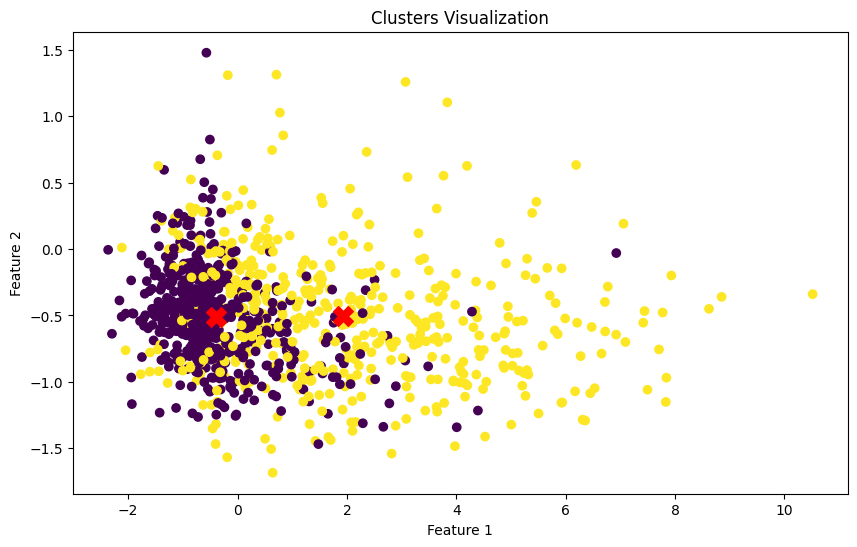

Cluster 0 - Imagen más representativa:


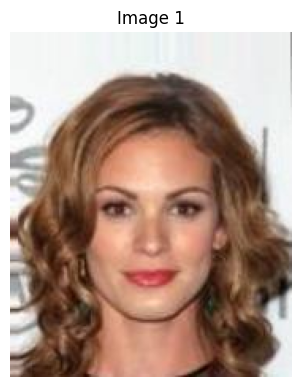

Cluster 1 - Imagen más representativa:


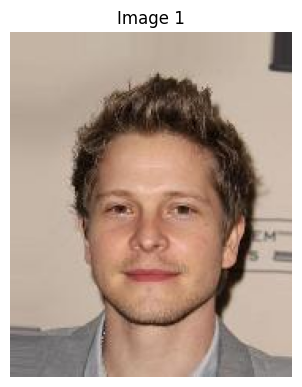

In [6]:
# Código principal
if __name__ == "__main__":
    # Cargar imágenes
    image_folder = 'img_align_celeba/'  
    images, image_paths = load_images(image_folder)
    print(f'Total de imágenes cargadas: {len(images)}')

    # Normalizar imágenes
    normalized_images = normalize_images(images)

    # Extraer características
    print('Extrayendo características...')
    features = extract_features(normalized_images)
   # Realizar clustering
    print('Realizando clustering...')
    cluster_labels, kmeans = perform_clustering(features, n_clusters=2)

    # Visualizar clusters
    plot_clusters(features, cluster_labels, kmeans)

    # Encontrar imágenes representativas
    representative_images = find_representative_images(features, cluster_labels, image_paths, kmeans)

    # Mostrar imágenes representativas
    for cluster, img_paths in representative_images.items():
        print(f'Cluster {cluster} - Imagen más representativa:')
        show_images(img_paths)

### Evaluación de Clasificación de Género

Clase que evalúa los resultados de clustering en función del género. Permite asignar etiquetas de género a los clusters, calcular métricas de evaluación (exactitud, matriz de confusión), visualizar la distribución de predicciones y mostrar ejemplos de imágenes por cluster. Además, incluye métodos para predecir el género de una imagen específica y mostrar predicciones aleatorias.

In [7]:

class GenderClassificationEvaluator:
    def __init__(self, cluster_labels, image_paths, kmeans):
        self.cluster_labels = cluster_labels
        self.image_paths = image_paths
        self.kmeans = kmeans
        self.labels_map = {}  # Mapeo de cluster a género
        self.predicted_labels = None
        
    def assign_gender_to_clusters(self, cluster_0_gender='hombre'):
        """
        Asignar género a cada cluster después de la inspección visual.
        cluster_0_gender: 'hombre' o 'mujer' - el género que representa el cluster 0.
        """
        if cluster_0_gender.lower() == 'hombre':
            self.labels_map = {0: 'Hombre', 1: 'Mujer'}
        else:
            self.labels_map = {0: 'Mujer', 1: 'Hombre'}
        
        # Convertir cluster_labels a etiquetas de género
        self.predicted_labels = np.array([self.labels_map[label] for label in self.cluster_labels])
        
    def evaluate_clusters(self, true_labels=None):
        """
        Evaluar los clusters y mostrar métricas.
        true_labels: etiquetas verdaderas si están disponibles.
        """
        if true_labels is not None:
            # Calcular métricas
            accuracy = accuracy_score(true_labels, self.predicted_labels)
            report = classification_report(true_labels, self.predicted_labels)
            conf_matrix = confusion_matrix(true_labels, self.predicted_labels)
            
            # Visualizar resultados
            self._plot_evaluation_metrics(accuracy, conf_matrix)
            print("\nReporte de Clasificación:")
            print(report)
        
        # Mostrar distribución de clusters
        self._plot_cluster_distribution()
    
    def _plot_evaluation_metrics(self, accuracy, conf_matrix):
        """Visualizar métricas de evaluación."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Matriz de confusión
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=list(self.labels_map.values()),
                    yticklabels=list(self.labels_map.values()), ax=ax1)
        ax1.set_title(f'Matriz de Confusión\nAccuracy: {accuracy:.2%}')
        ax1.set_xlabel('Predicción')
        ax1.set_ylabel('Valor Real')
        
        # Distribución de predicciones
        counts = np.bincount(self.cluster_labels)
        ax2.bar(list(self.labels_map.values()), counts)
        ax2.set_title('Distribución de Predicciones')
        ax2.set_ylabel('Cantidad de Imágenes')
        
        plt.tight_layout()
        plt.show()
    
    def _plot_cluster_distribution(self):
        """Visualizar distribución de clusters."""
        unique, counts = np.unique(self.predicted_labels, return_counts=True)
        plt.figure(figsize=(8, 8))
        plt.pie(counts, labels=[f'{label}\n({count:,})' for label, count in zip(unique, counts)],
                autopct='%1.1f%%', startangle=90)
        plt.title('Distribución de Género en el Dataset')
        plt.axis('equal')
        plt.show()
    
    def show_cluster_examples(self, examples_per_cluster=5):
        """Mostrar ejemplos de cada cluster."""
        for cluster in range(self.kmeans.n_clusters):
            # Obtener índices de imágenes para este cluster
            cluster_indices = np.where(self.cluster_labels == cluster)[0]
            
            # Asegúrate de que haya ejemplos disponibles
            if len(cluster_indices) == 0:
                print(f"No hay ejemplos en el cluster {cluster}.")
                continue
            
            # Seleccionar ejemplos aleatorios
            sample_indices = np.random.choice(cluster_indices, 
                                               size=min(examples_per_cluster, len(cluster_indices)), 
                                               replace=False)
            
            # Mostrar imágenes
            plt.figure(figsize=(20, 4))
            for idx, img_idx in enumerate(sample_indices, 1):
                img = Image.open(self.image_paths[img_idx])
                plt.subplot(1, examples_per_cluster, idx)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'{self.labels_map[cluster]}')  # Mostrar el género correcto según el cluster
            
            plt.suptitle(f'Ejemplos de Cluster: {self.labels_map[cluster]}')
            plt.show()
    
    def predict_gender(self, image_path):
        """Predecir género para una imagen específica."""
        # Procesar la imagen igual que en el entrenamiento
        img = Image.open(image_path).convert('RGB')
        img = img.resize((128, 128))  # Usar el mismo tamaño que en el entrenamiento
        
        # Mostrar la imagen y su predicción
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        
        # Obtener índice en image_paths
        try:
            idx = self.image_paths.index(image_path)
            prediction = self.predicted_labels[idx]
            plt.title(f'Predicción: {prediction}')
        except ValueError:
            plt.title('Imagen no encontrada en el dataset')
        
        plt.axis('off')
        plt.show()
        
    def show_random_prediction(self):
        """Mostrar una predicción aleatoria."""
        idx = np.random.choice(len(self.image_paths))  # Seleccionar un índice aleatorio
        img = Image.open(self.image_paths[idx])
        
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Predicción: {self.predicted_labels[idx]}')
        
        plt.show()


### Uso de la Clase de Evaluación de Género

Este fragmento de código demuestra cómo utilizar la clase GenderClassificationEvaluator para asignar etiquetas de género a los clusters después de realizar un clustering, evaluar los resultados obtenidos, mostrar ejemplos de imágenes de cada cluster y hacer una predicción aleatoria sobre una imagen del conjunto de datos.

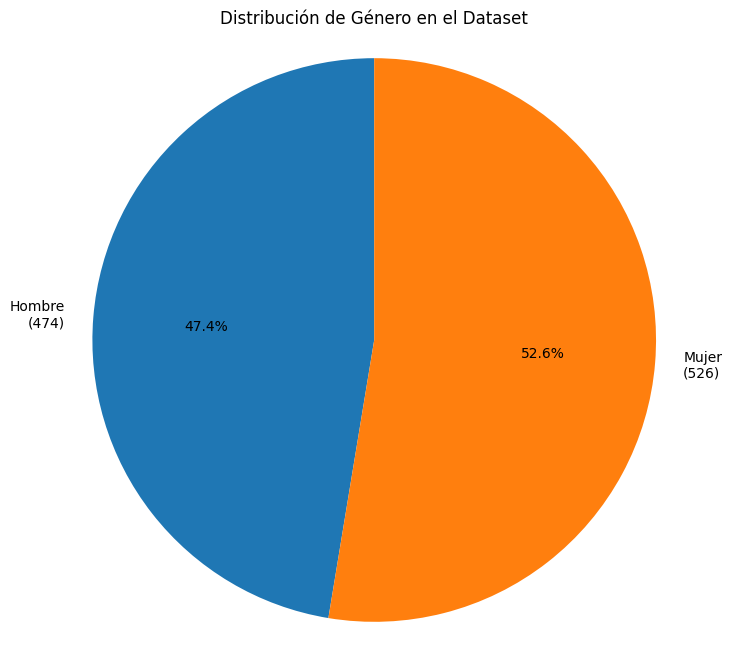

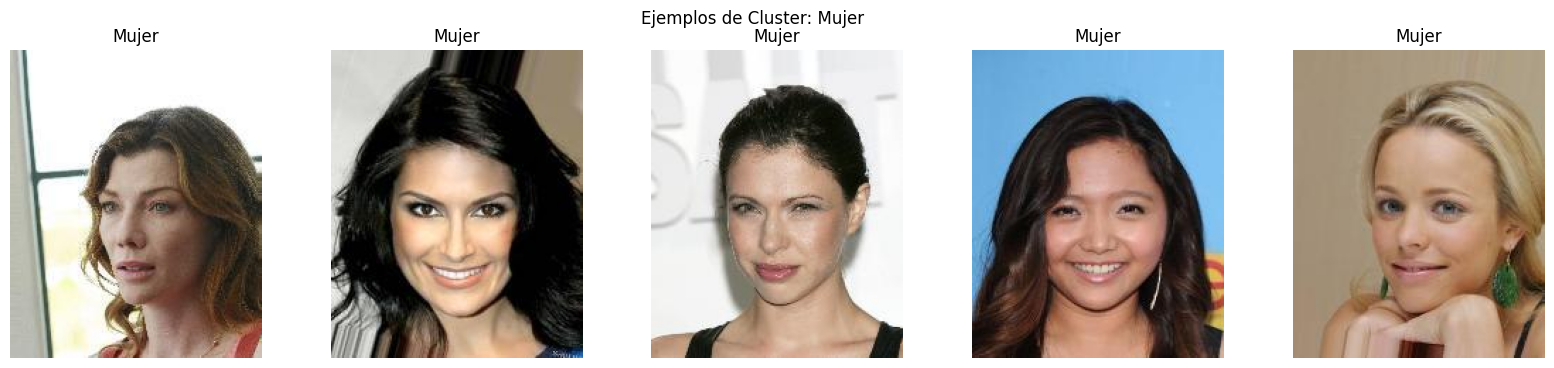

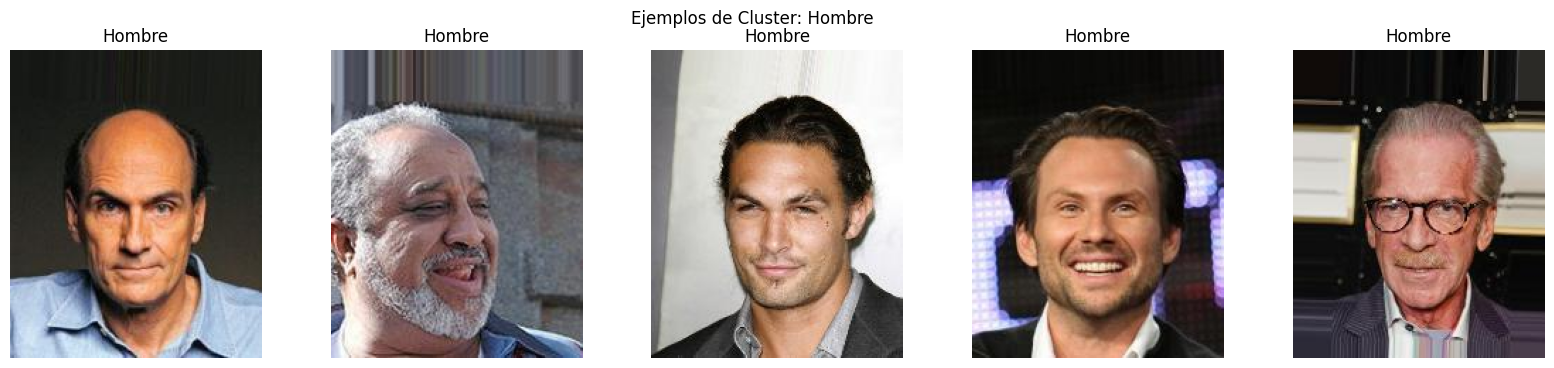

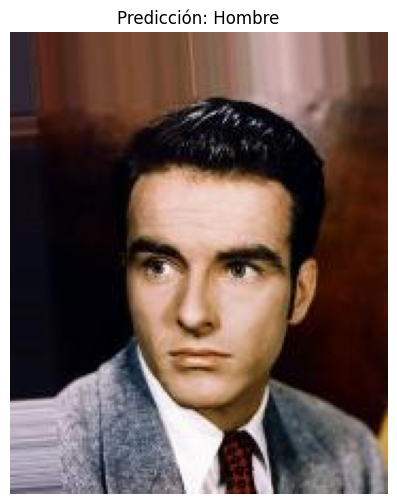

In [8]:
# Crear el evaluador
evaluator = GenderClassificationEvaluator(cluster_labels, image_paths, kmeans)

# Asignar género a los clusters después de inspección visual
# Cambiar 'hombre' a 'mujer' si el cluster 0 es 'mujer'
# Revisa las imágenes y asegúrate de que las etiquetas se asignen correctamente
evaluator.assign_gender_to_clusters(cluster_0_gender='mujer')  # Cambiar a 'mujer' o 'hombre' según corresponda

# Evaluar resultados
evaluator.evaluate_clusters()

# Mostrar ejemplos de cada cluster
evaluator.show_cluster_examples()

# Mostrar una predicción aleatoria
evaluator.show_random_prediction()

### Carga y Evaluación con Etiquetas Verdaderas:

Este código carga las etiquetas verdaderas de género desde un archivo CSV, limitando la carga a las primeras 1000 muestras. Luego, crea una instancia de GenderClassificationEvaluator, asigna etiquetas de género a los clusters, y evalúa la precisión del modelo al comparar las etiquetas verdaderas con las predicciones, mostrando el porcentaje de precisión si las longitudes de ambas listas coinciden.

In [9]:


# Cargar etiquetas verdaderas desde el archivo CSV, pero solo las primeras 1000
def load_true_labels(csv_file, num_samples=1000):
    df = pd.read_csv(csv_file)
    # Seleccionamos solo las primeras 1000 filas si es necesario
    df = df.iloc[:num_samples]
    # Convertimos la columna 'Male' a etiquetas de género
    true_labels = df['Male'].apply(lambda x: 'Hombre' if x == 1 else 'Mujer').values
    return true_labels

# Cargar las etiquetas verdaderas limitadas a 1000
true_labels = load_true_labels('list_attr_celeba.csv', num_samples=1000)

# Crear el evaluador
evaluator = GenderClassificationEvaluator(cluster_labels, image_paths, kmeans)

# Asignar género a los clusters después de la inspección visual
evaluator.assign_gender_to_clusters(cluster_0_gender='mujer')  # Ajusta según la inspección

# Evaluar resultados y calcular la precisión si las longitudes coinciden
if len(true_labels) == len(evaluator.predicted_labels):
    accuracy = accuracy_score(true_labels, evaluator.predicted_labels)
    print(f"Precisión del modelo: {accuracy * 100:.2f}%")
else:
    print("Error: Las longitudes de las etiquetas verdaderas y predichas no coinciden.")


Precisión del modelo: 91.60%


# Aprendisaje activo

### Clase ActiveLearningGenderClassifier

Esta clase implementa un clasificador de género con un enfoque de aprendizaje activo, utilizando clustering para agrupar características de imágenes y ajustar el modelo en función de etiquetas verdaderas y correcciones. Permite evaluar la confianza en las predicciones y realizar reentrenamientos con correcciones.

In [10]:
class ActiveLearningGenderClassifier:
    def __init__(self, features, image_paths, n_clusters=2):
        self.features = features
        self.image_paths = image_paths
        self.n_clusters = n_clusters
        self.kmeans = None
        self.cluster_labels = None
        self.predicted_labels = None
        self.confidence_scores = None
        self.true_labels = None
        self.labels_map = {}
        
    def initial_clustering(self):
        """
        Realizar el clustering inicial y calcular la confianza
        """
        print("Realizando clustering inicial...")
        self.kmeans = KMeans(n_clusters=self.n_clusters)
        self.cluster_labels = self.kmeans.fit_predict(self.features)
        
        # Calcular distancias a los centroides para la confianza
        distances = np.zeros((len(self.features), self.n_clusters))
        for i in range(self.n_clusters):
            distances[:, i] = np.linalg.norm(self.features - self.kmeans.cluster_centers_[i], axis=1)
        
        # Calcular scores de confianza
        sorted_distances = np.sort(distances, axis=1)
        self.confidence_scores = 1 - (sorted_distances[:, 0] / (sorted_distances[:, 1] + 1e-10))
        
        return self.cluster_labels
    
    def load_true_labels(self, csv_path):
        """
        Cargar las etiquetas verdaderas del dataset CelebA
        """
        print("Cargando etiquetas verdaderas...")
        df = pd.read_csv(csv_path)
        
        # Convertir nombres de archivo a solo el nombre base
        current_filenames = [os.path.basename(path) for path in self.image_paths]
        
        # Filtrar y obtener las etiquetas correspondientes
        matching_labels = []
        for filename in current_filenames:
            if filename in df['image_id'].values:
                label = df[df['image_id'] == filename]['Male'].iloc[0]
                matching_labels.append('Hombre' if label == 1 else 'Mujer')
            else:
                matching_labels.append(None)
                
        self.true_labels = np.array(matching_labels)
        return self.true_labels
    
    def assign_clusters(self):
        """
        Asignar etiquetas de género a los clusters basado en las etiquetas verdaderas
        """
        if self.true_labels is None:
            raise ValueError("Debe cargar las etiquetas verdaderas primero")
            
        # Contar género mayoritario en cada cluster
        cluster_0_males = sum(1 for i in range(len(self.cluster_labels)) 
                            if self.cluster_labels[i] == 0 and self.true_labels[i] == 'Hombre')
        cluster_0_females = sum(1 for i in range(len(self.cluster_labels)) 
                              if self.cluster_labels[i] == 0 and self.true_labels[i] == 'Mujer')
        
        # Asignar etiquetas basado en la mayoría
        if cluster_0_males > cluster_0_females:
            self.labels_map = {0: 'Hombre', 1: 'Mujer'}
        else:
            self.labels_map = {0: 'Mujer', 1: 'Hombre'}
            
        # Convertir cluster_labels a etiquetas de género
        self.predicted_labels = np.array([self.labels_map[label] for label in self.cluster_labels])
        
        # Calcular y mostrar accuracy inicial
        accuracy = accuracy_score(self.true_labels, self.predicted_labels)
        print(f"\n🎯 Precisión inicial del modelo: {accuracy:.2%}")
        
        return self.predicted_labels
    
    def show_low_confidence_predictions(self, n_samples=5):
        """
        Mostrar las predicciones con menor confianza
        """
        print("\nMostrando predicciones con menor confianza...")
        low_conf_indices = np.argsort(self.confidence_scores)[:n_samples]
        
        plt.figure(figsize=(20, 4))
        for idx, img_idx in enumerate(low_conf_indices, 1):
            img = Image.open(self.image_paths[img_idx])
            plt.subplot(1, n_samples, idx)
            plt.imshow(img)
            plt.axis('off')
            title = f'Pred: {self.predicted_labels[img_idx]}\n'
            title += f'Real: {self.true_labels[img_idx]}\n'
            title += f'Conf: {self.confidence_scores[img_idx]:.2f}'
            plt.title(title)
        
        plt.suptitle('Imágenes con Menor Confianza en la Predicción')
        plt.show()
        return low_conf_indices
    
    def retrain_with_corrections(self, correction_indices):
        """
        Reentrenar el modelo usando las etiquetas corregidas
        """
        print("\nReentrenando el modelo con correcciones...")
        
        # Crear nueva matriz de características con más peso para las muestras corregidas
        weighted_features = np.copy(self.features)
        for idx in correction_indices:
            weighted_features = np.vstack([weighted_features, self.features[idx]])
        
        # Reentrenar K-means
        self.kmeans = KMeans(n_clusters=self.n_clusters)
        new_cluster_labels = self.kmeans.fit_predict(weighted_features)
        self.cluster_labels = new_cluster_labels[:len(self.features)]
        
        # Recalcular confianza
        distances = np.zeros((len(self.features), self.n_clusters))
        for i in range(self.n_clusters):
            distances[:, i] = np.linalg.norm(self.features - self.kmeans.cluster_centers_[i], axis=1)
        
        sorted_distances = np.sort(distances, axis=1)
        self.confidence_scores = 1 - (sorted_distances[:, 0] / (sorted_distances[:, 1] + 1e-10))
        
        # Reasignar clusters
        self.assign_clusters()
        
        # Calcular y mostrar nueva accuracy
        new_accuracy = accuracy_score(self.true_labels, self.predicted_labels)
        print(f"\n🎯 Precisión después del reentrenamiento: {new_accuracy:.2%}")
        
        return new_accuracy
    
    def show_random_prediction(self):
        """
        Mostrar una predicción aleatoria
        """
        print("\nMostrando predicción aleatoria...")
        idx = np.random.choice(len(self.image_paths))
        img = Image.open(self.image_paths[idx])
        
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        title = f'Predicción: {self.predicted_labels[idx]}\n'
        title += f'Etiqueta Real: {self.true_labels[idx]}\n'
        title += f'Confianza: {self.confidence_scores[idx]:.2f}'
        plt.title(title)
        plt.show()


### Función implement_active_learning

 Esta función implementa el proceso completo de aprendizaje activo para clasificar el género de imágenes. Utiliza la clase ActiveLearningGenderClassifier para realizar clustering, cargar etiquetas verdaderas, asignar clusters, evaluar la precisión, mostrar ejemplos con baja confianza y reentrenar el modelo con correcciones.

In [11]:
def implement_active_learning(features, image_paths):
    """
    Implementar el proceso completo de active learning
    """
    # Crear el clasificador
    classifier = ActiveLearningGenderClassifier(features, image_paths)
    
    # Realizar clustering inicial
    classifier.initial_clustering()
    
    # Cargar etiquetas verdaderas
    classifier.load_true_labels('list_attr_celeba.csv')
    
    # Asignar clusters y mostrar accuracy inicial
    classifier.assign_clusters()
    
    # Mostrar ejemplos de baja confianza
    low_conf_indices = classifier.show_low_confidence_predictions(n_samples=5)
    
    # Reentrenar con las correcciones
    final_accuracy = classifier.retrain_with_corrections(low_conf_indices)
    
    # Mostrar una predicción aleatoria
    classifier.show_random_prediction()
    
    return classifier

### Código Principal

El siguiente código principal se encarga de cargar imágenes, normalizarlas, extraer sus características y luego implementar el aprendizaje activo para clasificar el género de las imágenes utilizando la clase ActiveLearningGenderClassifier

Total de imágenes cargadas: 1000
Extrayendo características...
Realizando clustering inicial...
Cargando etiquetas verdaderas...

🎯 Precisión inicial del modelo: 91.20%

Mostrando predicciones con menor confianza...


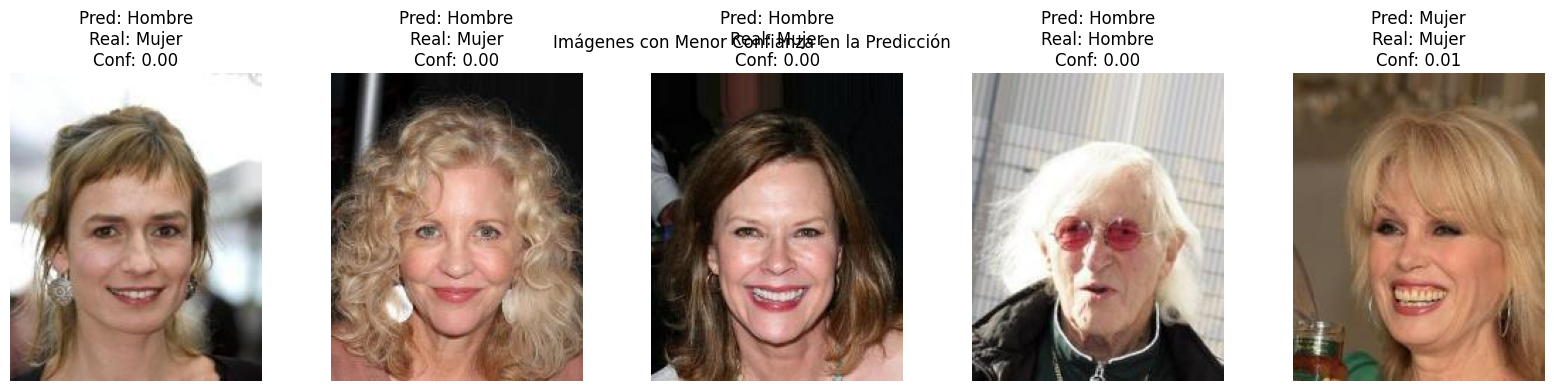


Reentrenando el modelo con correcciones...

🎯 Precisión inicial del modelo: 91.50%

🎯 Precisión después del reentrenamiento: 91.50%

Mostrando predicción aleatoria...


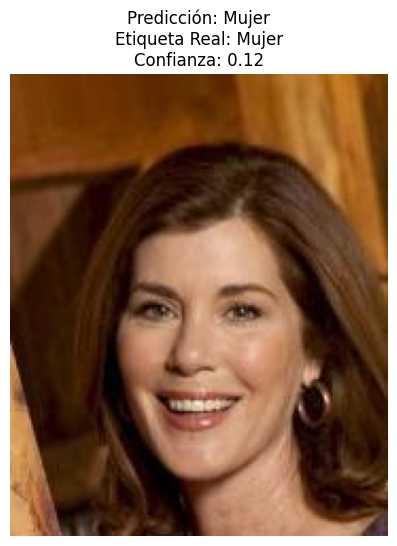

In [12]:
# Código principal
if __name__ == "__main__":
    # Cargar imágenes
    image_folder = 'img_align_celeba/'  # Ajusta esta ruta
    images, image_paths = load_images(image_folder)
    print(f'Total de imágenes cargadas: {len(images)}')

    # Normalizar imágenes
    normalized_images = normalize_images(images)

    # Extraer características
    print('Extrayendo características...')
    features = extract_features(normalized_images)

    # Implementar active learning
    classifier = implement_active_learning(features, image_paths)